In [75]:
from math import log


def viterbi(obs_states, hidden_states, init_prob, trans_prob, emis_prob):
    d_viterbi = []
    # Initialisation
    log_probabilities = [log(init_prob[k]) + log(emis_prob[k][obs_states[0]]) for k in hidden_states]
    previous_state = None
    d_viterbi.append({"log_prob": log_probabilities, "prev_s" : previous_state})
    # Do Viterbi
    for i in range(1, len(obs_states)):
        log_probabilities = []
        previous_state = []
        for l in hidden_states:
            trans_prob_to_l = [d_viterbi[i-1]["log_prob"][k] +\
                                log(trans_prob[k][l]) for k in hidden_states]
            max_log_prob = max(trans_prob_to_l)
            log_probabilities.append(max_log_prob + log(emis_prob[l][obs_states[i]]))
            previous_state.append(trans_prob_to_l.index(max_log_prob))
        d_viterbi.append({"log_prob": log_probabilities, "prev_s": previous_state})
    # Last state
    last_prob = max(d_viterbi[-1]["log_prob"])
    last_state = d_viterbi[-1]["log_prob"].index(last_prob)
    # Tracing back
    h_states = [0 for i in range(len(obs_states))]
    h_states[-1] = last_state
    for i in range(1, len(obs_states)):
        prev_state = d_viterbi[-i]["prev_s"][h_states[-i]]
        h_states[-i-1] = prev_state
    return (h_states, last_prob)
    

In [50]:
import random
from dishonest_casino import dishonest_casino_play

fair_prob = [1./6, 1./6, 1./6, 1./6, 1./6, 1./6]
unfair_prob = [1./10, 1./10, 1./10, 1./10, 1./10, 1./2]
initial_prob = [0.5, 0.5]
switch_to_loaded_dice_prob = 0.05
switch_to_fair_dice_prob = 0.1
n = 200000

h, v = dishonest_casino_play(n=n, fair_prob=fair_prob, unfair_prob=unfair_prob,
                             prob_switch_to_unfair=switch_to_loaded_dice_prob,
                             prob_switch_to_fair=switch_to_fair_dice_prob,
                             initial_dice=random.randint(0,1))


In [51]:
obs_states = [i-1 for i in v]
hidden_states = [0, 1]
initial_prob = [0.5, 0.5]
trans_prob = [[0.95, 0.05], [0.1, 0.9]]
emis_prob = [[1./6, 1./6, 1./6, 1./6, 1./6, 1./6],
             [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]]

estim_h, prob = viterbi(obs_states, hidden_states, initial_prob, trans_prob, emis_prob)

In [57]:
def compute_viterbi_accuracy(sample_size, fair_prob, unfair_prob,
                             prob_switch_to_unfair, prob_switch_to_fair,
                             trans_prob, emis_prob):
    h, v = dishonest_casino_play(n=sample_size, fair_prob=fair_prob, unfair_prob=unfair_prob,
                             prob_switch_to_unfair=switch_to_loaded_dice_prob,
                             prob_switch_to_fair=switch_to_fair_dice_prob,
                             initial_dice=random.randint(0,1))
    obs_states = [i-1 for i in v]
    estim_h, prob = viterbi(obs_states, hidden_states=[0, 1], init_prob=[0.5, 0.5], 
                            trans_prob=trans_prob, emis_prob=emis_prob)
    failed = [abs(i-j) for (i, j) in zip(h, estim_h)]
    accuracy = 1 - sum(failed)/len(failed)
    return accuracy
    

In [93]:
compute_viterbi_accuracy(300, fair_prob, unfair_prob,
                             switch_to_loaded_dice_prob, switch_to_fair_dice_prob,
                             trans_prob, emis_prob)

0.8366666666666667

In [52]:
failed = [abs(i-j) for (i, j) in zip(h, estim_h)]
accuracy = 1 - sum(failed)/len(failed)
print(accuracy)

0.796915


In [8]:
def viterbi2(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    for st in states:
        V[0][st] = {"prob": start_p[st] * emit_p[st][obs[0]], "prev": None}
    # Run Viterbi when t > 0
    for t in range(1, len(obs)):
        V.append({})
        for st in states:
            max_tr_prob = max(V[t-1][prev_st]["prob"]*trans_p[prev_st][st] for prev_st in states)
            for prev_st in states:
                if V[t-1][prev_st]["prob"] * trans_p[prev_st][st] == max_tr_prob:
                    max_prob = max_tr_prob * emit_p[st][obs[t]]
                    V[t][st] = {"prob": max_prob, "prev": prev_st}
                    break
    #for line in dptable(V):
    #    print(line)
    opt = []
    # The highest probability
    max_prob = max(value["prob"] for value in V[-1].values())
    previous = None
    # Get most probable state and its backtrack
    for st, data in V[-1].items():
        if data["prob"] == max_prob:
            opt.append(st)
            previous = st
            break
    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]
    return (opt, max_prob)

    #print 'The steps of states are ' + ' '.join(opt) + ' with highest probability of %s' % max_prob

def dptable(V):
    # Print a table of steps from dictionary
    yield " ".join(("%12d" % i) for i in range(len(V)))
    for state in V[0]:
        yield "%.7s: " % state + " ".join("%.7s" % ("%f" % v[state]["prob"]) for v in V)

In [9]:
h2, prob2 = viterbi2(obs_states, [0, 1], [0.5, 0.5], trans_prob, emis_prob)

In [10]:
failed2 = [abs(i-j) for i,j in zip(h, h2)]
accuracy2 = 1 - sum(failed2)/len(failed2)

print(accuracy2)

0.8033333333333333


In [11]:
prob2

3.916993678073754e-241

In [12]:
prob

-553.5576829708554

In [13]:
log(prob2)

-553.5576829708541

In [91]:
# Doing histogram

accuracy_list = []
prob_list = []
for i in range(100000):
    accuracy_list.append(compute_viterbi_accuracy(300, fair_prob, unfair_prob,
                             switch_to_loaded_dice_prob, switch_to_fair_dice_prob,
                             trans_prob, emis_prob))

(array([  1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   7.00000000e+00,
          1.50000000e+01,   1.60000000e+01,   2.60000000e+01,
          5.10000000e+01,   8.10000000e+01,   8.70000000e+01,
          1.80000000e+02,   1.83000000e+02,   2.76000000e+02,
          3.99000000e+02,   5.73000000e+02,   7.07000000e+02,
          9.29000000e+02,   1.14000000e+03,   1.44900000e+03,
          1.86400000e+03,   2.23000000e+03,   2.77100000e+03,
          3.26700000e+03,   5.17800000e+03,   4.47900000e+03,
          4.95200000e+03,   5.64900000e+03,   5.97500000e+03,
          6.03100000e+03,   6.40900000e+03,   6.40400000e+03,
          6.12900000e+03,   5.81400000e+03,   5.36800000e+03,
          4.79000000e+03,   5.35000000e+03,   3.25200000e+03,
          2.42700000e+03,   1.90200000e+03,   1.42500000e+03,
          8.94000000e+02,   6.38000000e+02,   3.59000000e+02,
          1.71000000e+02,   9.40000000e+01,   3.40000000e+01,
        

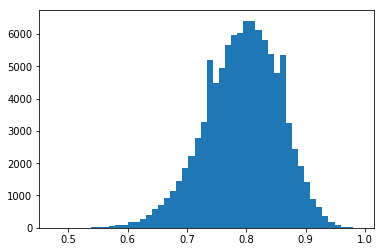

In [92]:
plt.hist(accuracy_list, bins = 50)

In [26]:
# Doing histogram for Wikipedia's method

n = 300
accuracy_list = []
prob_list = []
for i in range(1000):
    h, v = dishonest_casino_play(n=n, fair_prob=fair_prob, unfair_prob=unfair_prob,
                             prob_switch_to_unfair=switch_to_loaded_dice_prob,
                             prob_switch_to_fair=switch_to_fair_dice_prob,
                             initial_dice=random.randint(0,1))
    estim_h, prob = viterbi2(obs_states, hidden_states, initial_prob, trans_prob, emis_prob)
    failed = [abs(i-j) for i, j in zip(h, estim_h)]
    accuracy = 1 - sum(failed)/len(failed)
    accuracy_list.append(accuracy)
    prob_list.append(prob)

(array([   6.,   18.,   40.,  118.,  162.,  212.,  217.,  139.,   74.,   14.]),
 array([ 0.33666667,  0.39366667,  0.45066667,  0.50766667,  0.56466667,
         0.62166667,  0.67866667,  0.73566667,  0.79266667,  0.84966667,
         0.90666667]),
 <a list of 10 Patch objects>)

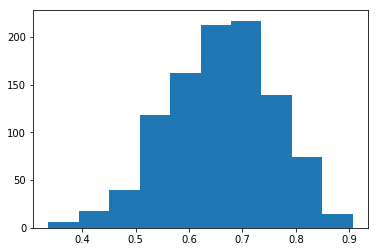

In [27]:
plt.hist(accuracy_list)